<a href="https://colab.research.google.com/github/tayfununal/hamiltonian_ex/blob/main/symplectic_euler.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [19]:
#simplektik euler
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Input, Model
from tensorflow.keras.layers import Dense

plt.style.use('seaborn-poster')

np.random.seed(1)
tf.random.set_seed(1)

initial_point= [0., 1.]

def symplectic_euler(h=0.05, initial_point= [0., 1.]):

    t = np.arange(0, 2*np.pi, h)

    q = np.zeros(t.shape[0])
    p = np.zeros(t.shape[0])

    q[0] = initial_point[0]
    p[0] = initial_point[1]
    
    for i in range(0, t.shape[0]-1):
      q[i + 1] = (1-h**2) * q[i] + h * p[i]
      p[i + 1] = p[i] - h * q[i]

    return q, p, t

q_symp , p_symp, t = symplectic_euler()
print("shape of q :", q_symp.shape ,"\nshape of p:", p_symp.shape, "\nsize of t:", len(t))

def grand_truth_plot(h = 0.1):
  t = np.arange(0,2*np.pi,0.3)
  q = np.sin(t)
  p = np.cos(t)
  plt.scatter(q,p)

def pred_plot(q, p):
  plt.plot(q[:, ], p[:,], c = "red")
  plt.xlabel('q', fontsize=17,fontweight="bold",fontname="Times New Roman")
  plt.ylabel('p', fontsize=17,fontweight="bold",fontname="Times New Roman")
  plt.title("Phase Diagram", fontsize=17,fontweight="bold",fontname="Times New Roman")

shape of q : (126,) 
shape of p: (126,) 
size of t: 126


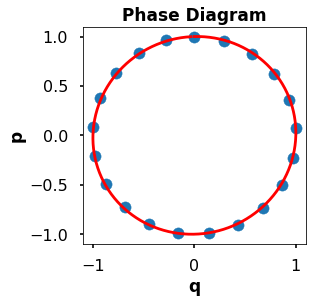

In [20]:
plt.figure(figsize = (4, 4))

# Simplectic solution plot
pred_plot(q=q_symp, p=p_symp)

# Grand truth solution plot
grand_truth_plot()
plt.show()

In [21]:
# Symplectic Euler method solutions
z = np.concatenate((q_symp.reshape(-1,1), p_symp.reshape(-1,1)) , axis=1)
t = t

In [22]:
# NN input and target values
target = np.concatenate((q_symp.reshape(-1,1), p_symp.reshape(-1,1)) , axis=1)[1:]
input_t = t[1:]

In [23]:
# Neural network with MSE loss
np.random.seed(1)
tf.random.set_seed(1)

inp = Input(shape=(1,))

x = Dense(512, activation="relu", name="hidden_layer_1")(inp)
x = Dense(512, activation="relu", name="hidden_layer_2")(x)
x = Dense(512, activation="relu", name="hidden_layer_3")(x)
x = Dense(512, activation="relu", name="hidden_layer_4")(x)
x = Dense(2)(x)
out = tf.constant([[0.,1.]], dtype=tf.float32) + (1-tf.math.exp(-inp**2)) * tf.matmul(x, tf.constant([[0., -1.],[1., 0.]]))

model = Model(inputs=inp, outputs=out)
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_4 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 hidden_layer_1 (Dense)         (None, 512)          1024        ['input_4[0][0]']                
                                                                                                  
 hidden_layer_2 (Dense)         (None, 512)          262656      ['hidden_layer_1[0][0]']         
                                                                                                  
 tf.math.pow_3 (TFOpLambda)     (None, 1)            0           ['input_4[0][0]']                
                                                                                            

In [24]:
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)

model.compile(optimizer=opt, loss="mse")

model.fit(x=input_t, y=target, epochs=8000, batch_size=64)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
2/2 [==============================] - 0s 23ms/step - loss: 1.3640e-06
Epoch 5502/8000
2/2 [==============================] - 0s 25ms/step - loss: 1.4014e-06
Epoch 5503/8000
2/2 [==============================] - 0s 25ms/step - loss: 1.4771e-06
Epoch 5504/8000
2/2 [==============================] - 0s 26ms/step - loss: 1.3749e-06
Epoch 5505/8000
2/2 [==============================] - 0s 23ms/step - loss: 1.3674e-06
Epoch 5506/8000
2/2 [==============================] - 0s 28ms/step - loss: 1.3968e-06
Epoch 5507/8000
2/2 [==============================] - 0s 24ms/step - loss: 1.3921e-06
Epoch 5508/8000
2/2 [==============================] - 0s 22ms/step - loss: 1.8065e-06
Epoch 5509/8000
2/2 [==============================] - 0s 23ms/step - loss: 1.6513e-06
Epoch 5510/8000
2/2 [==============================] - 0s 22ms/step - loss: 1.7795e-06
Epoch 5511/8000
2/2 [==============================] - 0s 25ms/step - loss: 2.7367e-06
Epoch 5512/8

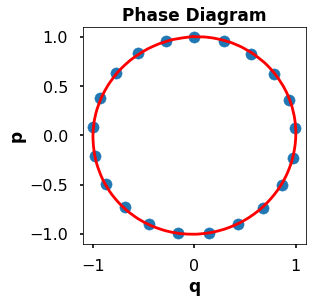

In [25]:
test_t = np.arange(0, 2*np.pi, 0.001)
prediction = model(test_t)

q = prediction[:,0]
p = prediction[:,1]

plt.figure(figsize = (4, 4))

# NN with mse solition 
pred_plot(q, p )

# Grand truth solution plot
grand_truth_plot()

plt.show()

In [26]:
# Neural network with Energy Preserved Loss
np.random.seed(1)
tf.random.set_seed(1)

inp_energy = Input(shape=(1,))

x_energy = Dense(512, activation="relu", name="hidden_layer_1")(inp_energy)
x_energy = Dense(512, activation="relu", name="hidden_layer_2")(x_energy)
x_energy = Dense(512, activation="relu", name="hidden_layer_3")(x_energy)
x_energy = Dense(512, activation="relu", name="hidden_layer_4")(x_energy)
x_energy = Dense(2)(x_energy)
out_energy = tf.constant([[0.,1.]], dtype=tf.float32) + (1-tf.math.exp(-inp_energy**2)) * tf.matmul(x_energy, tf.constant([[0., -1.],[1., 0.]]))

model_energy = Model(inputs=inp_energy, outputs=out_energy)
model_energy.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_5 (InputLayer)           [(None, 1)]          0           []                               
                                                                                                  
 hidden_layer_1 (Dense)         (None, 512)          1024        ['input_5[0][0]']                
                                                                                                  
 hidden_layer_2 (Dense)         (None, 512)          262656      ['hidden_layer_1[0][0]']         
                                                                                                  
 tf.math.pow_4 (TFOpLambda)     (None, 1)            0           ['input_5[0][0]']                
                                                                                            

In [27]:
# Hamiltonian Equation
def H(z):
  return tf.reduce_sum((z**2)/2,axis=1)

# loss function
def custom_loss(y_true, y_pred):

  return tf.keras.losses.MSE(y_true, y_pred) + 20 * tf.keras.losses.MSE(0.5, H(y_pred))

In [28]:
opt_energy = tf.keras.optimizers.Adam(learning_rate=0.0001)

model_energy.compile(optimizer=opt_energy, loss=custom_loss)

model_energy.fit(x=input_t, y=target, epochs=8000, batch_size=64)

Görüntülenen çıkış son 5000 satıra kısaltıldı.
2/2 [==============================] - 0s 26ms/step - loss: 7.9511e-05
Epoch 5502/8000
2/2 [==============================] - 0s 26ms/step - loss: 9.6168e-05
Epoch 5503/8000
2/2 [==============================] - 0s 23ms/step - loss: 6.9584e-05
Epoch 5504/8000
2/2 [==============================] - 0s 24ms/step - loss: 7.3562e-05
Epoch 5505/8000
2/2 [==============================] - 0s 29ms/step - loss: 6.6298e-05
Epoch 5506/8000
2/2 [==============================] - 0s 27ms/step - loss: 8.3158e-05
Epoch 5507/8000
2/2 [==============================] - 0s 25ms/step - loss: 6.5642e-05
Epoch 5508/8000
2/2 [==============================] - 0s 25ms/step - loss: 6.8287e-05
Epoch 5509/8000
2/2 [==============================] - 0s 25ms/step - loss: 7.9231e-05
Epoch 5510/8000
2/2 [==============================] - 0s 23ms/step - loss: 8.3488e-05
Epoch 5511/8000
2/2 [==============================] - 0s 26ms/step - loss: 1.1002e-04
Epoch 5512/8

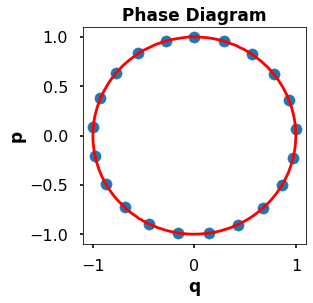

In [29]:
test_t = np.arange(0, 2*np.pi, 0.001)
prediction_energy = model_energy(test_t)

q_energy = prediction_energy[:,0]
p_energy = prediction_energy[:,1]

plt.figure(figsize = (4, 4))

# NN with mse solition 
pred_plot(q_energy, p_energy )

# Grand truth solution plot
grand_truth_plot()

plt.show()

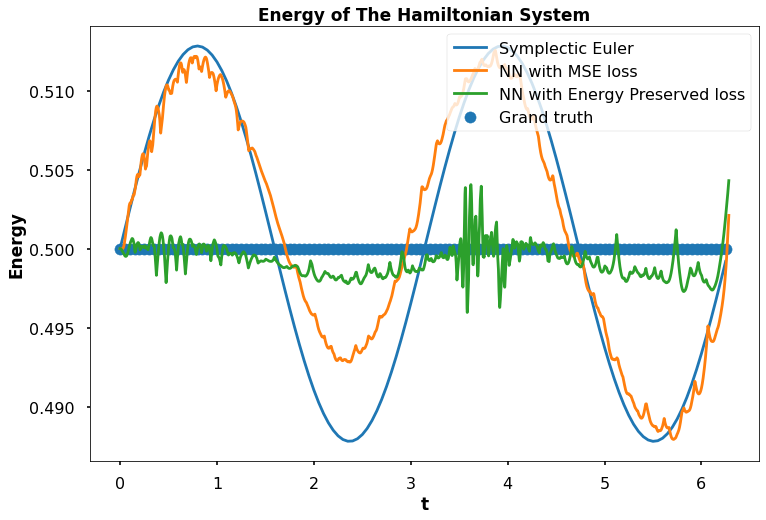

In [31]:
plt.figure(figsize=(12,8))

plt.scatter(t, [0.5 for i in range(t.shape[0])], label="Grand truth")
plt.plot(t ,H(z), label= "Symplectic Euler")
plt.plot(test_t, H(model(test_t)), label="NN with MSE loss")
plt.plot(test_t, H(model_energy(test_t)), label="NN with Energy Preserved loss")

plt.title("Energy of The Hamiltonian System", fontsize=17,fontweight="bold",fontname="Times New Roman")
plt.xlabel("t",fontsize=17,fontweight="bold",fontname="Times New Roman")
plt.ylabel("Energy",fontsize=17,fontweight="bold",fontname="Times New Roman")
plt.legend(loc="upper right")
plt.show()